# 💳 Task 4 – Behavioral Risk Feature Engineering for BNPL Credit Scoring  
📘 Version: 2025-07-03  

This notebook designs and implements a **feature engineering pipeline** for **Bati Bank’s BNPL Credit Scoring Initiative**, transforming raw transactional data into a **model-ready feature set** for risk prediction.  

It builds upon the outputs from **Task 3 – Proxy Label Engineering** by creating structured, explainable features that capture key dimensions of customer behavior, spending patterns, and engagement risk. These features will serve as the inputs to the predictive models in **Task 5 – Model Training & Evaluation**.  

---  

**Challenge:** B5W5 – Credit Scoring & Risk Modeling  
**Company:** Bati Bank (in partnership with an eCommerce platform)  
**Author:** Nabil Mohamed  
**Branch:** `task-4-feature-engineering`  
**Date:** July 2025  

---  

## 📌 Notebook Outline  

| Section | Description |
|---------|-------------|
| 1️⃣ Imports & Project Setup | Load libraries, define file paths, ensure reproducibility |
| 2️⃣ Load Enriched Dataset | Load transaction dataset with RFM metrics and proxy labels |
| 3️⃣ Aggregate Feature Engineering | Generate customer-level transaction aggregates (count, value, variance) |
| 4️⃣ Temporal Feature Engineering | Extract time-based behavioral patterns (recency, frequency, active hours) |
| 5️⃣ Categorical Encoding | Apply encoding to key categorical predictors |
| 6️⃣ Missing Value Handling & Scaling | Apply robust imputation and feature scaling |
| 7️⃣ Feature Set Assembly | Merge engineered features with proxy labels for modeling |
| 8️⃣ Save Model-Ready Dataset | Export final dataset for Task 5 modeling |
| 9️⃣ Next Steps Preview | Outline transition to model development and explainability |

---  

## ✏️ Key Design Principles:  

- Focus on **behavioral risk signals**—turning transactions into defensible borrower profiles.  
- Prioritize **model explainability** by including interpretable features alongside any complex transformations (e.g., Weight of Evidence).  
- Ensure **pipeline reproducibility** using **sklearn’s Pipeline** and **modular design** for seamless integration with Task 5.  
- All outputs must be **ready for immediate modeling and SHAP explainability**, minimizing technical debt in downstream tasks.  


In [1]:
# ------------------------------------------------------------------------------
# 🛠 Ensure Notebook Runs from Project Root (for src/ imports to work)
# ------------------------------------------------------------------------------

import os
import sys

# If running from /notebooks/, move up to project root
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("📂 Changed working directory to project root")

# Add project root to sys.path so `src/` modules can be imported
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"✅ Added to sys.path: {project_root}")

# Optional: verify file presence to confirm we're in the right place
expected_path = "data/raw"
print(
    "📁 Output path ready"
    if os.path.exists(expected_path)
    else f"⚠️ Output path not found: {expected_path}"
)

📂 Changed working directory to project root
✅ Added to sys.path: c:\Users\admin\Documents\GIT Repositories\b5w5-credit-scoring-challenge
📁 Output path ready


## 📦 Imports & Environment Setup

This cell loads the core libraries required for **feature engineering, data transformation, and preprocessing** for **Bati Bank’s BNPL Credit Risk Modeling**.

Imports are grouped by function:

- **Data handling:** `pandas`, `numpy`
- **Visualization:** `matplotlib`, `seaborn`
- **Date/time analysis:** `datetime`, `pandas.to_datetime`
- **Preprocessing & encoding:** `scikit-learn` for aggregation, scaling, and encoding
- **System & utilities:** `os`, `warnings`, `pathlib`

The environment is configured for **reproducibility, clean visuals, and clear output formatting** for downstream model training and explainability.


In [2]:
# ---------------------------
# 📦 Imports & Environment Setup
# ---------------------------

# Data handling
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Visualization
import matplotlib.pyplot as plt  # For plotting static visualizations
import seaborn as sns  # For enhanced statistical visualizations

# Date/time analysis
from datetime import datetime  # For working with date and time objects
from pandas.api.types import CategoricalDtype  # For defining ordered categories

# Preprocessing & encoding
from sklearn.preprocessing import StandardScaler  # For standardizing numerical features
from sklearn.preprocessing import (
    OneHotEncoder,
)  # For one-hot encoding of categorical features
from sklearn.preprocessing import (
    LabelEncoder,
)  # For label encoding of categorical features
from sklearn.pipeline import (
    Pipeline,
)  # For creating reproducible transformation pipelines
from sklearn.impute import SimpleImputer  # For missing value imputation

# System & utilities
import os  # For file path operations
import warnings  # For suppressing warnings
from pathlib import Path  # For handling file system paths

# Configure display settings for pandas
pd.set_option("display.max_columns", None)  # Show all columns in DataFrame outputs
pd.set_option(
    "display.float_format", "{:,.2f}".format
)  # Format floats to 2 decimal places

# Ignore non-critical warnings to keep output clean
warnings.filterwarnings("ignore")

# Set seaborn style for consistent visuals
sns.set(
    style="whitegrid", context="notebook"
)  # Apply white grid style for better readability

## 📥 Load & Preview Enriched Transaction Dataset (Task 4 Feature Engineering)

This step loads the **enriched transaction dataset** (`enriched_transactions_with_proxy_labels.csv`) prepared in **Task 3 – Proxy Label Engineering**.  
This dataset includes behavioral features such as **Recency, Frequency, Monetary (RFM) metrics**, **fraud tags**, and the generated **proxy risk labels** (`risk_category`, `is_high_risk`).

Key actions in this step:
- Load the **proxy-labeled** dataset from `data/processed/enriched_transactions_with_proxy_labels.csv` using the `CreditDataLoader` utility.
- Verify data structure: row count, columns, data types, sample preview.
- Provide clear diagnostics and robust error handling.
- Ensure compatibility with downstream **feature engineering and model training** in Task 5.

---


In [3]:
# ------------------------------------------------------------------------------
# 📦 Load Enriched Credit Transaction Data (Task 4 Loader)
# ------------------------------------------------------------------------------

# Import the custom CreditDataLoader from src
from src.data_loader import CreditDataLoader  # Defensive, reusable data loader class

# Define the path to the enriched transaction dataset with proxy labels
data_path = (
    "data/processed/enriched_transactions_with_proxy_labels.csv"  # Path to input data
)

# Initialize the loader class with the file path
loader = CreditDataLoader(filepath=data_path)  # Create instance of loader

# Load the dataset using robust error handling
try:
    df = loader.load()  # Load data into pandas DataFrame
    print(
        f"✅ Data loaded successfully: {df.shape[0]:,} rows × {df.shape[1]:,} columns"
    )  # Print row/column counts
except Exception as e:
    print(
        f"❌ Failed to load enriched transaction data: {e}"
    )  # Print error message if loading fails

✅ Transaction dataset loaded: 95,662 rows × 27 columns
✅ Data loaded successfully: 95,662 rows × 27 columns


## ⚙️ Apply Feature Engineering Pipeline (Task 4 – Feature Engineering)

This step applies the **modular, production-grade feature engineering pipeline** to the loaded enriched transaction dataset using the `DataProcessor` utility class.  
The pipeline transforms the raw proxy-labeled data into a **model-ready feature set** for downstream credit risk modeling and explainability.

The pipeline performs the following transformations:

- 📊 **Aggregate Feature Engineering:**  
  Customer-level behavioral features including transaction counts, totals, averages, variability (Amount, Value, RFM).
  
- 🕒 **Temporal Feature Extraction:**  
  Transaction patterns based on **hour of day**, **day of the week**, **month**, and **year**.

- 🔤 **Categorical Encoding:**  
  Encodes key categorical predictors using **Label Encoding** (default) or **One-Hot Encoding** (optional).

- 🩹 **Missing Value Handling & Scaling:**  
  Applies robust **median imputation** and **standardization** to numeric features using a reproducible **sklearn Pipeline**.

- 🧹 **Feature Set Assembly:**  
  Drops redundant identifiers and assembles a **clean, deduplicated dataset** ready for immediate model training and evaluation.

---

✅ This ensures compliance with the challenge brief’s requirements for **automated, reproducible, and explainable** feature engineering.


🔄 Initializing feature engineering processor...
🚀 Starting the feature engineering pipeline...
🚀 Starting full feature engineering pipeline...
✅ ID columns converted to numeric.
✅ Aggregates engineered.
✅ Temporal features extracted.
✅ All categorical features encoded.
✅ Missing values handled and scaling applied.
✅ Final dataset assembled: 77,761 rows × 39 columns.
✅ Feature engineering completed successfully.
🔢 Final dataset shape: 77,761 rows × 39 columns


,CurrencyCode,CountryCode,ProductCategory,Amount,Value,PricingStrategy,FraudResult,IsSharedAccount,Recency,Frequency,Monetary,FraudRisk,BehaviorCluster,BehavioralVarianceFlag,RiskScore,Amount_count,Amount_sum,Amount_mean,Amount_std,Amount_max,Amount_min,Value_sum,Value_mean,Value_std,FraudResult_sum,Recency_mean,Frequency_mean,Monetary_mean,TransactionHour,TransactionDayOfWeek,TransactionMonth,TransactionYear,AccountId,CustomerId,ProviderId,ProductId,ChannelId,risk_category,is_high_risk
0,0.00,0.00,-0.80,-0.05,-0.07,-0.35,-0.04,-0.82,-0.73,-0.31,-0.24,-0.04,-0.55,0.00,-0.50,-0.31,0.17,-0.07,-0.17,-0.19,0.16,-0.24,-0.10,-0.17,-0.10,-0.73,-0.31,-0.24,-2.16,-0.01,0.85,-0.99,"3,957.00","4,406.00",5,10.00,2,0,0
1,0.00,0.00,0.49,-0.05,-0.08,-0.35,-0.04,1.23,-0.73,-0.31,-0.24,-0.04,-0.55,0.00,-0.50,-0.31,0.17,-0.07,-0.17,-0.19,0.16,-0.24,-0.10,-0.17,-0.10,-0.73,-0.31,-0.24,-2.16,-0.01,0.85,-0.99,"4,841.00","4,406.00",3,6.00,1,0,0
2,0.00,0.00,-0.80,-0.05,-0.08,-0.35,-0.04,-0.82,3.34,-0.44,-0.25,-0.04,1.96,0.00,2.65,-0.44,0.17,-0.07,-0.20,-0.23,0.28,-0.25,-0.11,-0.20,-0.10,3.34,-0.44,-0.25,-2.16,-0.01,0.85,-0.99,"4,229.00","4,683.00",5,1.00,2,2,1
3,0.00,0.00,4.36,0.11,0.10,-0.35,-0.04,-0.82,-0.52,-0.40,-0.24,-0.04,-0.55,0.00,-0.50,-0.40,0.18,-0.01,-0.01,-0.04,0.05,-0.24,-0.03,0.00,-0.10,-0.52,-0.40,-0.24,-1.95,-0.01,0.85,-0.99,648.00,988.00,0,21.00,2,0,0
4,0.00,0.00,0.49,-0.06,-0.08,-0.35,-0.04,1.23,-0.52,-0.40,-0.24,-0.04,-0.55,0.00,-0.50,-0.40,0.18,-0.01,-0.01,-0.04,0.05,-0.24,-0.03,0.00,-0.10,-0.52,-0.40,-0.24,-1.95,-0.01,0.85,-0.99,"4,841.00",988.00,3,6.00,1,0,0


🔍 Generating correlation heatmap to check for high collinearity...


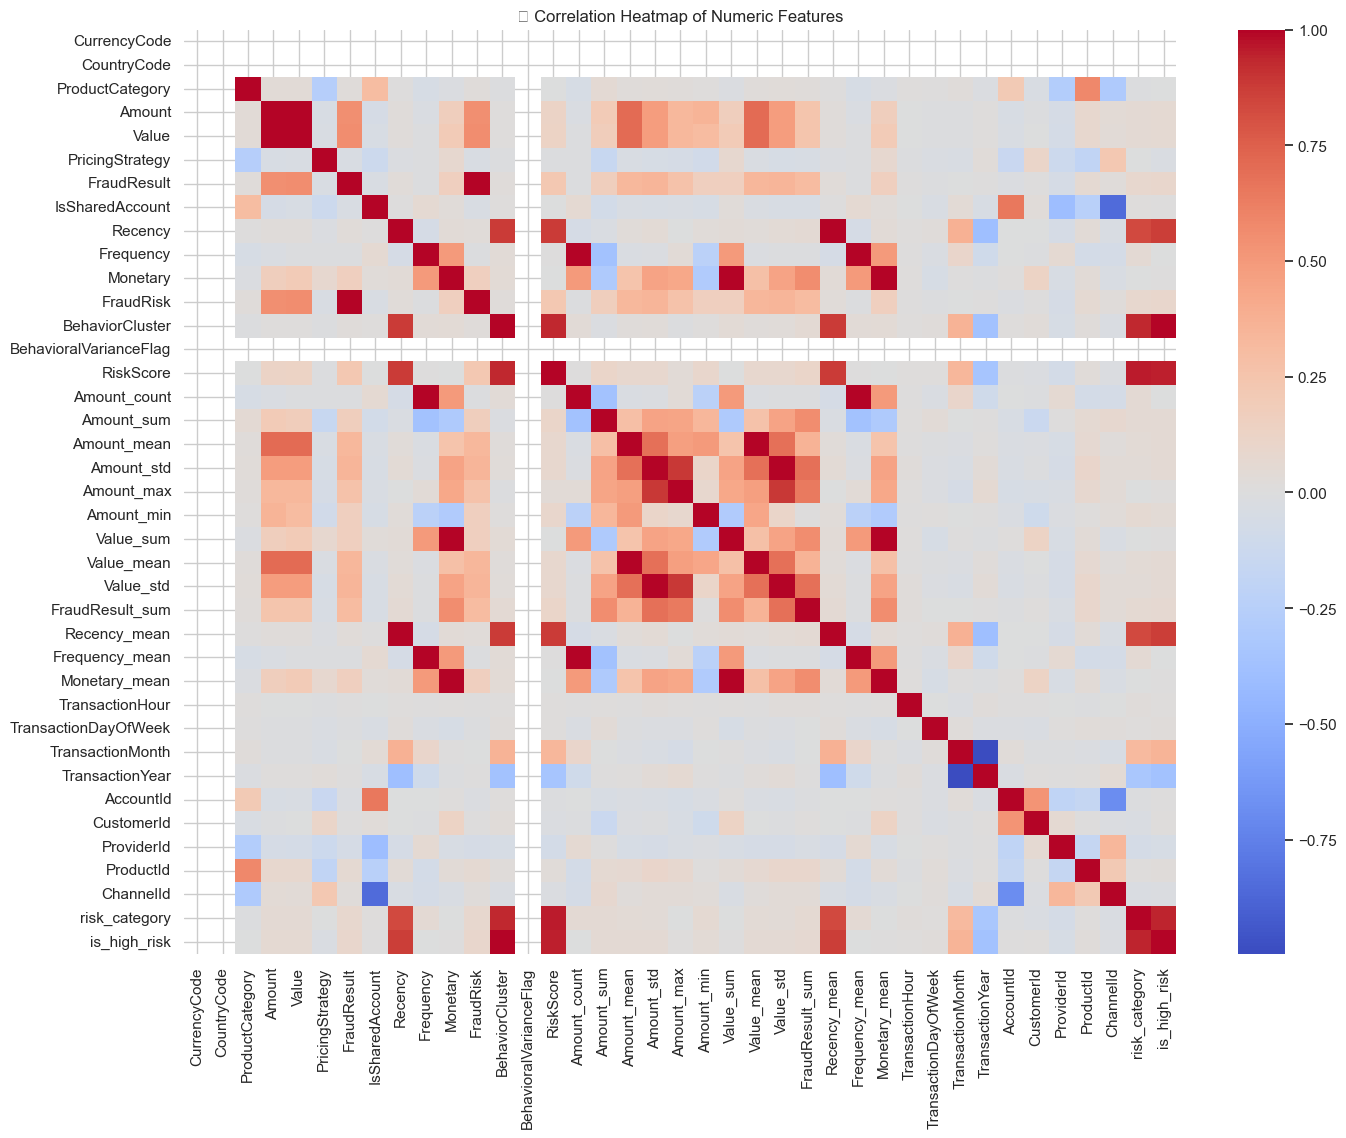

⚠️ Highly correlated pairs (>|0.85|):
  Value ⬌ Amount: 0.99
  FraudRisk ⬌ FraudResult: 1.00
  BehaviorCluster ⬌ Recency: 0.88
  RiskScore ⬌ Recency: 0.88
  RiskScore ⬌ BehaviorCluster: 0.93
  Amount_count ⬌ Frequency: 1.00
  Amount_max ⬌ Amount_std: 0.88
  Value_sum ⬌ Monetary: 1.00
  Value_mean ⬌ Amount_mean: 0.99
  Value_std ⬌ Amount_std: 1.00
  Value_std ⬌ Amount_max: 0.88
  Recency_mean ⬌ Recency: 1.00
  Recency_mean ⬌ BehaviorCluster: 0.88
  Recency_mean ⬌ RiskScore: 0.88
  Frequency_mean ⬌ Frequency: 1.00
  Frequency_mean ⬌ Amount_count: 1.00
  Monetary_mean ⬌ Monetary: 1.00
  Monetary_mean ⬌ Value_sum: 1.00
  TransactionYear ⬌ TransactionMonth: -1.00
  ChannelId ⬌ IsSharedAccount: -0.85
  risk_category ⬌ BehaviorCluster: 0.94
  risk_category ⬌ RiskScore: 0.95
  is_high_risk ⬌ Recency: 0.87
  is_high_risk ⬌ BehaviorCluster: 0.99
  is_high_risk ⬌ RiskScore: 0.95
  is_high_risk ⬌ Recency_mean: 0.87
  is_high_risk ⬌ risk_category: 0.94
✅ Correlation heatmap generated successfully.


In [4]:
# ------------------------------------------------------------------------------
# ⚙️ Apply Feature Engineering Pipeline + Correlation Heatmap (Task 4 Processor)
# ------------------------------------------------------------------------------

# Import the custom DataProcessor and CorrelationHeatmapGenerator from your src module
from src.labeling.data_processing import DataProcessor, CorrelationHeatmapGenerator

# Step 1️⃣ Initialize the DataProcessor with the loaded DataFrame
print("🔄 Initializing feature engineering processor...")

# Optional: Set use_one_hot=True for One-Hot Encoding (Label Encoding is faster, less sparse)
processor = DataProcessor(df, use_one_hot=False)  # Defensive initialization with enriched transaction data

# Step 2️⃣ Run the full feature engineering pipeline with verbose diagnostics
try:
    print("🚀 Starting the feature engineering pipeline...")

    # Execute all pipeline steps: aggregates, temporal, encoding, scaling, assembly
    final_df = processor.run_full_pipeline()

    print("✅ Feature engineering completed successfully.")
    print(f"🔢 Final dataset shape: {final_df.shape[0]:,} rows × {final_df.shape[1]:,} columns")

    # Optional: Preview the transformed dataset
    display(final_df.head())

except Exception as e:
    print(f"❌ Feature engineering pipeline failed: {e}")

# Step 3️⃣ Generate Correlation Heatmap for Feature Collinearity Check
try:
    print("🔍 Generating correlation heatmap to check for high collinearity...")

    # Initialize the heatmap generator with the processed dataset
    heatmap_generator = CorrelationHeatmapGenerator(final_df, threshold=0.85)

    # Plot the heatmap (no file saving for now)
    heatmap_generator.plot_heatmap(figsize=(16, 12), save_path=None)

    print("✅ Correlation heatmap generated successfully.")

except Exception as e:
    print(f"❌ Failed to generate correlation heatmap: {e}")

# ------------------------------------------------------------------------------
# ✅ Pipeline Overview (What this cell does):
# ------------------------------------------------------------------------------
# 1. 📊 Aggregate Feature Engineering → Customer-level behavior (transaction counts, totals, variance)
# 2. 🕒 Temporal Feature Extraction → Patterns by hour, day of week, month, year
# 3. 🔤 Categorical Encoding → Label or One-Hot encoding of predictors
# 4. 🩹 Missing Value Handling & Scaling → Median imputation + standardization
# 5. 🧹 Feature Set Assembly → Clean, deduplicated, model-ready dataset
# 6. 🛰 Correlation Heatmap → Visual check for multicollinearity risks (optional flagging)


In [5]:
# ------------------------------------------------------------------------------
# 💾 Save Final Model-Ready Data (Task 4 Output)
# ------------------------------------------------------------------------------

output_path = "data/processed/final_model_ready_data.csv"  # Define save path

try:
    final_df.to_csv(output_path, index=False)  # Save DataFrame to CSV
    print(
        f"✅ Model-ready dataset saved: {output_path} ({final_df.shape[0]:,} rows × {final_df.shape[1]:,} columns)"
    )
except Exception as e:
    print(f"❌ Failed to save model-ready dataset: {e}")

✅ Model-ready dataset saved: data/processed/final_model_ready_data.csv (77,761 rows × 39 columns)
